# Project - Water Potability Classification
Author: Osman Yaseen


In [221]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

We are going to follow the following workflow: Split data into training and test set. Use the training portion to find the best model (optionally using grid search) and cross-validation. Evaluate the *winner* on the test set.

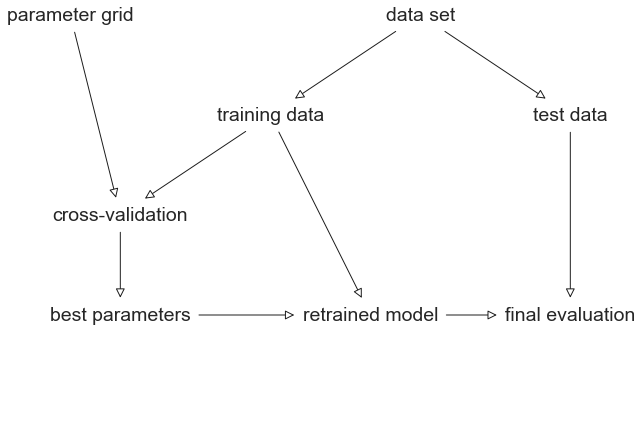

In [222]:
import mglearn
mglearn.plots.plot_grid_search_overview()

## 0. Function definitions

In [223]:
from sklearn.model_selection import cross_validate


def get_classifier_cv_score(model, X, y, scoring='accuracy', cv=7):
    '''Calculate train and validation scores of classifier (model) using cross-validation
        
        
        model (sklearn classifier): Classifier to train and evaluate
        X (numpy.array or pandas.DataFrame): Feature matrix
        y (numpy.array or pandas.Series): Target vector
        scoring (str): a scoring string accepted by sklearn.metrics.cross_validate()
        cv (int): number of cross-validation folds see sklearn.metrics.cross_validate()
        
        returns: mean training score, mean validation score
    
    '''
    cv_scores = cross_validate(model, X, y, scoring = scoring, return_train_score = True)
    
    return cv_scores['train_score'].mean(), cv_scores['test_score'].mean()

In [224]:
def print_grid_search_result(grid_search):
    '''Prints summary of best model from GridSearchCV object.
    
        For the best model of the grid search, print:
        - parameters 
        - cross-validation training score
        - cross-validation validation score 
        
        scores are printed with 3 decimal places.
    
        grid_search (sklearn GridSearchCV): Fitted GridSearchCV object
        
        returns: None
        
    '''
    print(grid_search.best_params_)
    print("Training score = {0:.3f} Validation score = {1:.3f}"
          .format(grid_search.cv_results_['mean_train_score'][np.where(grid_search.cv_results_['mean_test_score'] == grid_search.best_score_)[0][0]],
                  grid_search.best_score_)) # Training score is pulled from the same index as validation score

In [225]:
import mglearn

def plot_grid_search_results(grid_search):
    '''For grids with 2 hyperparameters, create a heatmap plot of test scores
        
        grid_search (sklearn GridSearchCV): Fitted GridSearchCV object
        
        uses mglearn.tools.heatmap() for plotting.
    
    '''
    results = pd.DataFrame(grid_search.cv_results_)

    params = sorted(grid_search.param_grid.keys())
    
    assert len(params) == 2, "We can only plot two parameters."
    
    # second dimension in reshape are rows, needs to be the fast changing parameter
    scores = np.array(results.mean_test_score).reshape(len(grid_search.param_grid[params[0]]),
                                                      len(grid_search.param_grid[params[1]]))
    
    
    # plot the mean cross-validation scores
    # x-axis needs to be the fast changing parameter
    mglearn.tools.heatmap(scores, 
                          xlabel=params[1], 
                          xticklabels=grid_search.param_grid[params[1]], 
                          ylabel=params[0], 
                          yticklabels=grid_search.param_grid[params[0]],
                          cmap="viridis", fmt="%0.3f")

In [226]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_actual, y_pred, labels, title=''):
    '''Creates a heatmap plot of the confusion matrix.
    
        y_actual (pandas.DataSeries or numpy.Array): Ground truth label vector
        y_pred (pandas.DataSeries or numpy.Array): Predicted label vector
        labels (list(str)): Class names used for plotting (ticklabels)
        title (str): Plot title
        
        uses sklearn.metrics.confusion_matrix
        
    '''
    mtrx = confusion_matrix(y_actual, y_pred)
    plt = sns.heatmap(mtrx, square = True, annot = True, cbar = False, xticklabels = labels, yticklabels = labels, fmt = 'd')
    plt.set_title(title)
    plt.set_xlabel("Predicted Value")
    plt.set_ylabel("True Value")   

## 1. Load data
kaggle - water potability
https://www.kaggle.com/adityakadiwal/water-potability/




In [227]:
# loading water potability data
data = pd.read_csv("water_potability.csv")
data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


## 2. Inspect the data 

Remove null values                                                                                               
Check if removal of null values requires resampling of the data

In [228]:
data = data.dropna()

In [229]:
data.Potability.value_counts()

0    1200
1     811
Name: Potability, dtype: int64

<AxesSubplot:ylabel='Potability'>

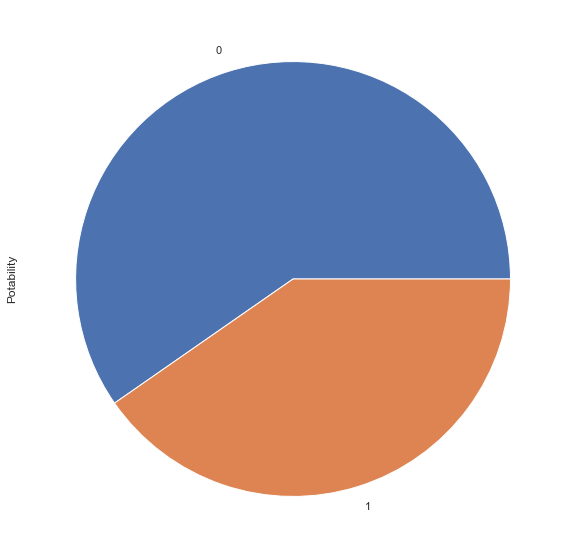

In [230]:
import matplotlib.pyplot as plt
import seaborn as sns


data.Potability.value_counts().plot(kind ='pie')

### 2.1 Resample the data 

In [231]:
count_potability_0, count_potability_1 = data.Potability.value_counts()

data_potability_0 = data[data['Potability'] == 0]
data_potability_1 = data[data['Potability'] == 1]

data_potability_0_under = data_potability_0.sample(count_potability_1)
data_balanced = pd.concat([data_potability_0_under, data_potability_1], axis=0)

print('Random under-sampling:')
print(data_balanced.Potability.value_counts())

Random under-sampling:
0    811
1    811
Name: Potability, dtype: int64


<AxesSubplot:ylabel='Potability'>

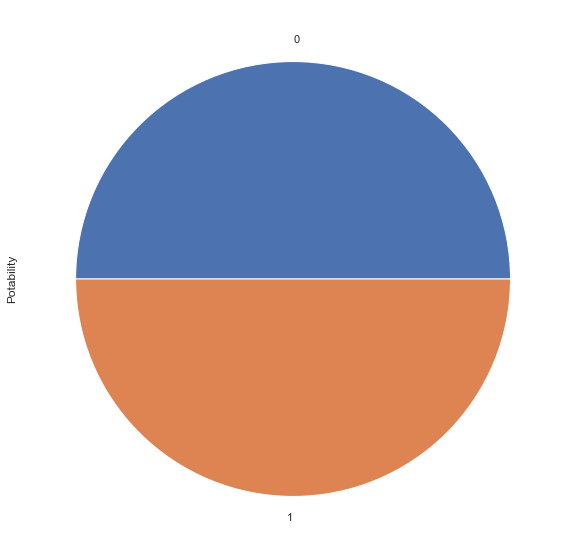

In [232]:
data_balanced.Potability.value_counts().plot(kind ='pie')

### 2.2 Prepare the feature matrix and target vector

Using the pandas `read_csv()` function, load the water potability data set into feature matrix `X` and target vector `y`.

Print shape and type of `X`, `y`.

In [233]:
print("data \nshape:", data_balanced.shape, "dimensions:", data_balanced.ndim, "type:", type(data_balanced))

X = data_balanced.drop(data.iloc[:, [9]], axis = 1)
print("X \nshape:", X.shape, "dimensions:", X.ndim, "type:", type(X))

y = data_balanced['Potability']
print("y \nshape:", y.shape, "dimensions:", y.ndim, "type:", type(y))

data 
shape: (1622, 10) dimensions: 2 type: <class 'pandas.core.frame.DataFrame'>
X 
shape: (1622, 9) dimensions: 2 type: <class 'pandas.core.frame.DataFrame'>
y 
shape: (1622,) dimensions: 1 type: <class 'pandas.core.series.Series'>


### 2.3 Range of each feature
To get an idea if the features are on the same scale, we inspect the range of features.

Print the minimum and maximum of each feature in `X`.

In [234]:
X.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
count,1622.000000,1622.000000,1622.000000,1622.000000,1622.000000,1622.000000,1622.000000,1622.000000,1622.000000
mean,7.101547,195.557914,21866.762195,7.127638,333.271864,425.943030,14.353929,66.356356,3.977182
std,1.543759,33.092719,8631.479009,1.604225,41.751002,81.507781,3.338031,16.081915,0.783053
min,0.227499,73.492234,320.942611,1.390871,129.000000,201.619737,2.200000,8.577013,1.450000
25%,6.117527,176.820776,15498.342736,6.122273,307.990001,365.312527,12.095919,55.914919,3.447791
50%,7.058524,197.076345,20541.315822,7.131338,332.125056,422.001517,14.326764,66.565709,3.986896
75%,8.040177,216.494843,27393.518584,8.104062,359.402819,481.942390,16.733110,77.153877,4.530839
max,13.349889,317.338124,56488.672413,13.127000,481.030642,753.342620,24.755392,124.000000,6.494749


### 2.4 Boxplot of features 
Using seaborn boxplot, plot all features. This provides a visual view of feature ranges.

Add y-axis label indicating units, and a title.

[Text(0.5, 0, 'features'),
 Text(0, 0.5, 'value'),
 Text(0.5, 1.0, 'Features Ranges')]

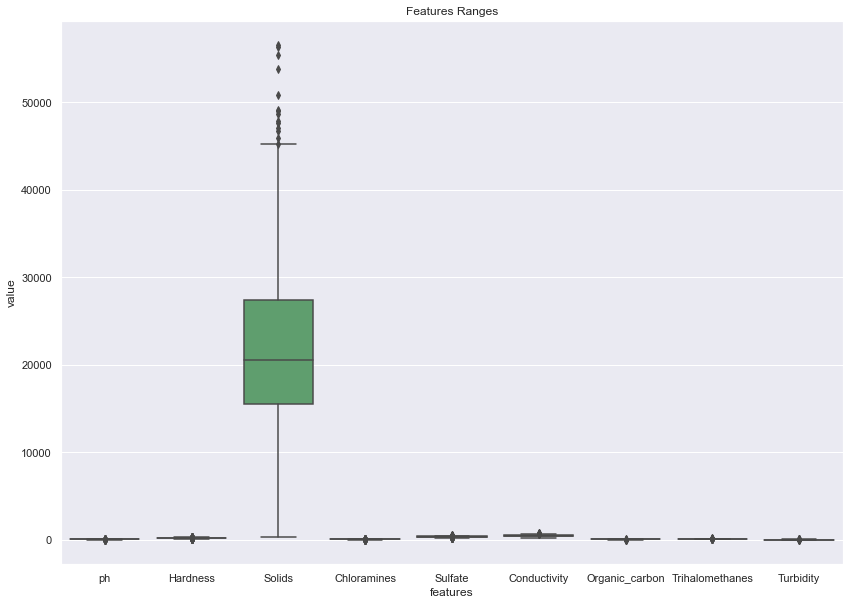

In [245]:
boxplot = sns.boxplot(data=X)
sns.set(rc = {'figure.figsize':(15,10)})
boxplot.set(xlabel="features", ylabel='value', title='Features Ranges')

[Text(0.5, 0, 'features'),
 Text(0, 0.5, 'value'),
 Text(0.5, 1.0, 'Features Ranges')]

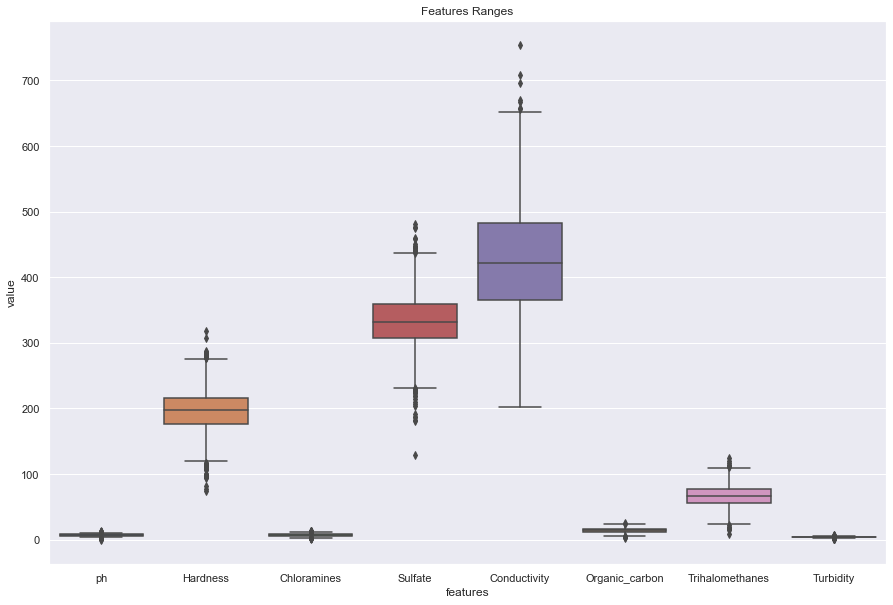

In [246]:
# Boxplot of all features except Solids

boxplot = sns.boxplot(data=X.drop(columns='Solids'))
sns.set(rc = {'figure.figsize':(10,10)})
boxplot.set(xlabel="features", ylabel='value', title='Features Ranges')

### 2.5 Scaling Features

In [249]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
features= X.columns
X[features] = sc.fit_transform(X[features])

### 2.6 Correlation heatmap of features 

To understand if pairs of features are potentially related, contain similar information, pair-wise cross-correlation can be calculated. Models benefit most from un-correlated features.

Using pandas `corr()` method, create the cross-correlations between all features. Plot this cross-correlation object using seaborn `heatmap()` with parameters `vmin=-1, vmax=1, annot=True, cmap='BrBG'`. Add a title.

Pandas `corr()` calculates [Pearson correlation ](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) :
>  It has a value between +1 and −1. A value of +1 is total positive linear correlation, 0 is no linear correlation, and −1 is total negative linear correlation.

[Text(0.5, 1.0, 'Features Heatmap')]

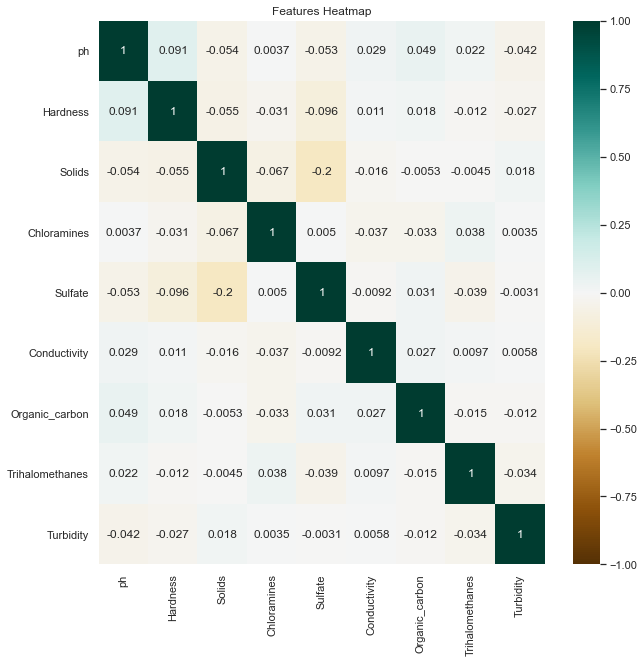

In [250]:
# add pairwise cross-correlation heatmap of features
corr = X.corr()
sns.heatmap(corr, vmin=-1, vmax=1, annot=True, cmap='BrBG').set(title='Features Heatmap')

## 3. Create training and test sets
Using scikit-learn `train_test_split()` with parameters `random_state=99`, `test_size=0.2'

In [315]:
# train_test_split()
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7, test_size=0.2)

## 4. Compare models using cross-validation
Create a list containing a `LogisticRegression()`, 
          `SVC()`,
          `BernoulliNB()`,
        `RandomForestClassifier(random_state=55)`, 
         `GradientBoostingClassifier(random_state=56)` objects.

Iterate this list, then:
- compute the **average precision** using `get_classifier_cv_score()` defined above, 
- rank the models based on validation **average precision** (best first),
- and print the ranked models training and validation scores with **3 decimal places**. 

Use training data and 7-fold cross-validation.

In [316]:
# cross-validation comparison 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

models = [LogisticRegression(), SVC(random_state=54), BernoulliNB(), RandomForestClassifier(random_state=55), GradientBoostingClassifier(random_state=56)]

results = []
for model in models:
    training_score, validation_score = get_classifier_cv_score(model, X_train, y_train, scoring = 'average_precision')
    results.append([model, training_score, validation_score])
    
results.sort(key=lambda x: x[2], reverse=True)

for i in results:
    print(i[0], "train_score={:.3f}".format(i[1]),"validation score={:.3f}".format(i[2]))

SVC(random_state=54) train_score=0.866 validation score=0.704
RandomForestClassifier(random_state=55) train_score=1.000 validation score=0.700
GradientBoostingClassifier(random_state=56) train_score=0.952 validation score=0.672
LogisticRegression() train_score=0.542 validation score=0.503
BernoulliNB() train_score=0.529 validation score=0.489


## 5. Hyperparameter tuning using grid search 

The inital cross-validation above showed that both DecisionTree based models might have merit. 

Support vector machine classifier might also perform well if properly tuned.

Next, hyperparameters are tuned using grid search.

### 5.1 SVC grid search
Perform grid search using `GridSearchCV` for the `SVC()`.

Grid search to use 7-fold cross-validation, and `average_precision` as the scoring function. Note that there is a `n_jobs` parameter to run search in parallel. Setting it to the number of CPU cores works well.

Use the following hyperparameters and values:
- `'C': [1, 10, 100, 1000]`
- `'gamma': [0.001, 0.01, 0.1, 1]`

Use `print_grid_search_result()` and `plot_grid_search_result()` functions defined above to show the results.

In [317]:
# grid search for SVC()
grid_search_cv_SVC = GridSearchCV(estimator=SVC(),
                                 param_grid={'C': [1, 10, 100, 1000],
                                             'gamma': [0.001, 0.01, 0.1, 1]},
                                 scoring='average_precision',
                                 n_jobs=-1,
                                 cv=7,
                                 return_train_score=True)

In [318]:
# perform the grid search by calling fit()
grid_search_cv_SVC.fit(X_train, y_train)

GridSearchCV(cv=7, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1, 10, 100, 1000],
                         'gamma': [0.001, 0.01, 0.1, 1]},
             return_train_score=True, scoring='average_precision')

In [319]:
# call print_grid_search_result() to print the results
print_grid_search_result(grid_search_cv_SVC)

{'C': 100, 'gamma': 0.01}
Training score = 0.805 Validation score = 0.722


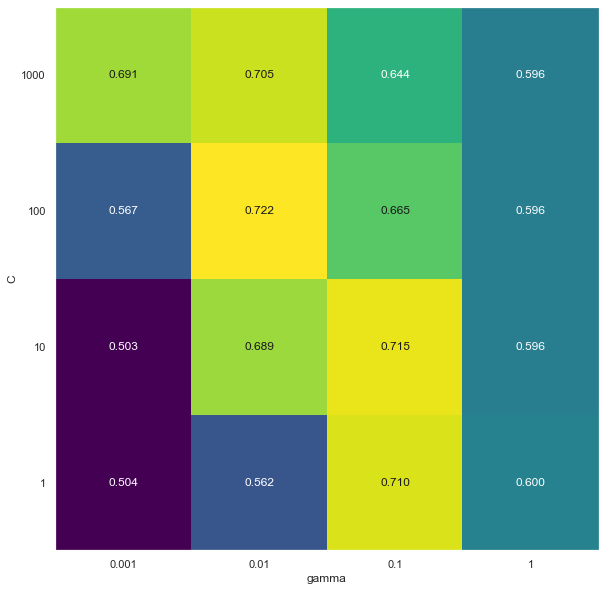

In [320]:
# call plot_grid_search_results() to plot validation metrics for all hyperparameter combinations
plot_grid_search_results(grid_search_cv_SVC)

### 5.2 Grid search for RandomForestClassifier 

Perform grid search using `GridSearchCV` for the `RandomForestClassifier(random_state=55)`.

Grid search to use 7-fold cross-validation, and `average_precision` as the scoring function. Note that there is a `n_jobs` parameter to run search in parallel. Setting it to the number of CPU cores works well.

Use the following hyperparameters and values:
- `'n_estimators': [110, 120, 130, 140]`
- `'max_depth': [13, 15, 17, 19]`

Use `print_grid_search_result()` and `plot_grid_search_result()` functions defined above to show the results.

In [321]:
# Setup grid search for RandomForestClassifier(random_state=55)
from sklearn.model_selection import GridSearchCV
grid_search_cv_RF = GridSearchCV(estimator=RandomForestClassifier(random_state=55),
                                 param_grid={'n_estimators': [110, 120, 130, 140],
                                            'max_depth': [13, 15, 17, 19]},
                                 scoring='average_precision',
                                 n_jobs=-1,
                                 cv=7,
                                 return_train_score=True)

In [322]:
# perform the grid search by calling fit()
grid_search_cv_RF.fit(X_train, y_train)

GridSearchCV(cv=7, estimator=RandomForestClassifier(random_state=55), n_jobs=-1,
             param_grid={'max_depth': [13, 15, 17, 19],
                         'n_estimators': [110, 120, 130, 140]},
             return_train_score=True, scoring='average_precision')

In [323]:
# call print_grid_search_result() to print the results
print_grid_search_result(grid_search_cv_RF)

{'max_depth': 13, 'n_estimators': 130}
Training score = 1.000 Validation score = 0.713


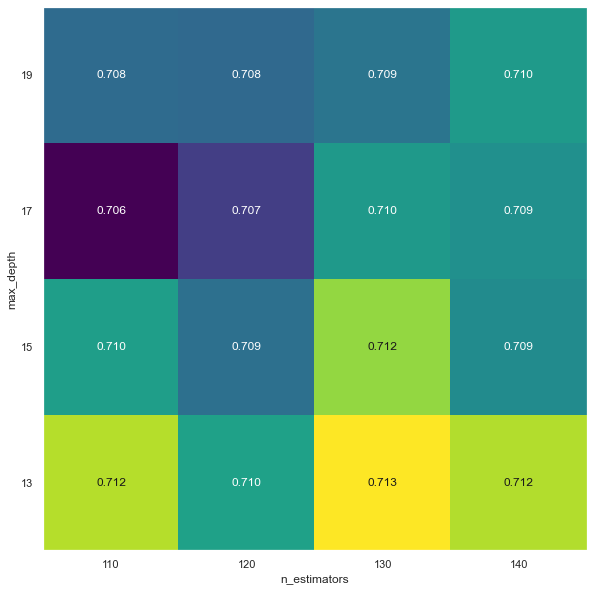

In [324]:
# call plot_grid_search_results() to plot validation metrics for all hyperparameter combinations
plot_grid_search_results(grid_search_cv_RF)

### 5.3 Gradient boosting classifier 
Perform grid search using `GridSearchCV` for the `GradientBoostingClassifier(max_depth=5, random_state=56)`.

Grid search to use 7-fold cross-validation, and `average_precision` as the scoring function. Note that there is a `n_jobs` parameter to run search in parallel. Setting it to the number of CPU cores works well.

Use the following hyperparameters and values:
- `'n_estimators': [50, 100, 200]`,
- `'learning_rate': [0.001, 0.01, 0.1, 1.0]`

Use `print_grid_search_result()` and `plot_grid_search_result()` functions defined above to show the results.

In [325]:
# Setup grid search for GradientBoostingClassifier(max_depth=5, random_state=56)
grid_search_cv_GB = GridSearchCV(estimator=GradientBoostingClassifier(max_depth=5, random_state=56),
                                 param_grid={'n_estimators': [50, 100, 200],
                                             'learning_rate': [0.001, 0.01, 0.1, 1.0]},
                                 scoring='average_precision',
                                 n_jobs=-1,
                                 cv=7,
                                 return_train_score=True)

In [326]:
# perform the grid search by calling fit()
grid_search_cv_GB.fit(X_train, y_train)

GridSearchCV(cv=7,
             estimator=GradientBoostingClassifier(max_depth=5, random_state=56),
             n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 1.0],
                         'n_estimators': [50, 100, 200]},
             return_train_score=True, scoring='average_precision')

In [327]:
# call print_grid_search_result() to print the results
print_grid_search_result(grid_search_cv_GB)

{'learning_rate': 0.01, 'n_estimators': 200}
Training score = 0.929 Validation score = 0.702


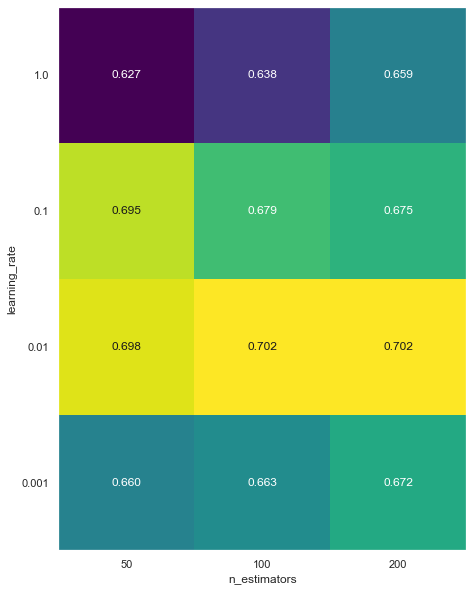

In [328]:
# call plot_grid_search_results() to plot validation metrics for all hyperparameter combinations
plot_grid_search_results(grid_search_cv_GB)

### *Question 1:* What are the training and validation scores of the three tuned (best) models? Summarize the results here.

Best Support Vector Classifier model:

Training score = 0.805 Validation score = 0.722

Best Random Forest Classifier model:

Training score = 1.000 Validation score = 0.713

Best Gradient Boosting Classifier model:

Training score = 0.929 Validation score = 0.702

## 6. Best model: Find a better threshold

### 6.1 Precision and recall curve

From the results above, it looks like `SVC()` performs well.

Using the training dataset and best `SVC()` from the grid search above:
1. Calculate predicted probabilities using `cross_val_predict()` with parameters `cv=7, method='predict_proba'`.
2. Plot the precision-recall curve indicating where the default threshold 0.5 lies (see lecture notebook for an example).

Include a legend and axis labels.


In [329]:
# Calculate predicted probabilities using cross_val_predict(cv=7, method='predict_proba')
from sklearn.model_selection import cross_val_predict

best_model = SVC(random_state = 54, C=100, gamma = 0.01, probability = True)
pred_prob = cross_val_predict(estimator=model,
                              X=X_train,
                              y=y_train,
                              cv=7,
                              method='predict_proba')

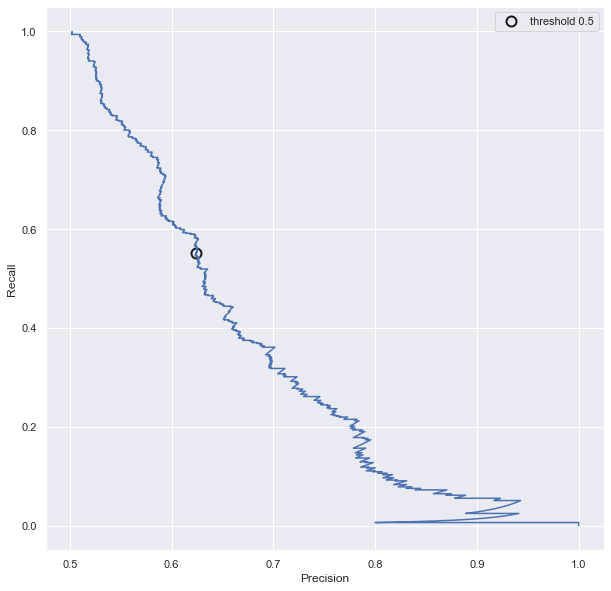

In [330]:
# Plot precision-recall curve
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(
    y_true=y_train, probas_pred=pred_prob[:, 1])

close_default = np.argmin(np.abs(thresholds - 0.5))
plt.plot(precision[close_default], recall[close_default], 'o', markersize=10,
         label="threshold 0.5", fillstyle="none", c='k', mew=2)

plt.plot(precision, recall)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="best");

### 6.2 Find a better threshold
It is important in this application to achieve high recall. Determine the probability threshold to achieve recall higher than 0.999. Store this threshold in a variable and print it.

In [331]:
# Find and print threshold for recall>0.999
high_recall_threshold = thresholds[np.where(recall > 0.999)[0].max()]
print(high_recall_threshold)

0.046154065108068666


## 7. Retrain best model
Retrain the best `SVC()` from the grid search above on the training dataset.

In [357]:
#Retrain SVC()
model_SVC = SVC(C=100, gamma = 0.01, probability = True)
model_SVC.fit(X_train, y_train)
print(model_SVC)
print(grid_search_cv_SVC.best_params_)



SVC(C=100, gamma=0.01, probability=True)
{'C': 100, 'gamma': 0.01}


## 8. Evaluate on test data

Using the retrained model and the test dataset:
- print the classification report
- plot the confusion matrix using plot_confusion_matrix()

Make sure the plot has class labels and a title.

Repeat these steps for the default threshold and the optimal threshold determined in step 7.

### 8.1 Evaluation with default threshold

In [360]:
# print classification report using default threshold
from sklearn.metrics import classification_report

y_pred_default = model_SVC.predict(X_test)

class_report_SVC_default = classification_report(y_test, y_pred_default)
print(class_report_SVC_default)

              precision    recall  f1-score   support

           0       0.64      0.80      0.71       165
           1       0.72      0.54      0.62       160

    accuracy                           0.67       325
   macro avg       0.68      0.67      0.66       325
weighted avg       0.68      0.67      0.66       325



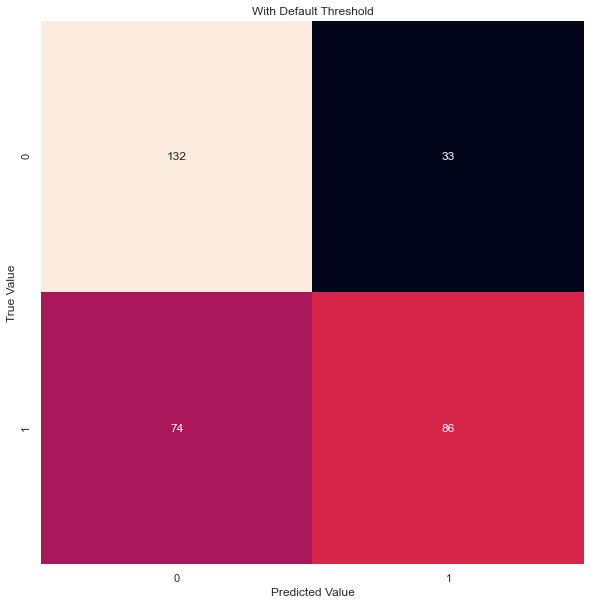

In [361]:
# call plot_confusion_matrix(), use LabelEncoder classes_ to get labels
from sklearn.preprocessing import LabelEncoder
labenc = LabelEncoder()
y_enc = labenc.fit_transform(y)
plot_confusion_matrix(y_actual=y_test, y_pred=y_pred_default, labels=labenc.classes_, title="With Default Threshold")

### *Question 2:* What are the precision, recall and accuracy on the test set using the default thresholds of the best SVC model?

Class 0 (Not Potable) 
precision = 0.64                                                                                                              
recall = 0.80                                                                                                    
Class 1 (Potable)                                                                                      
precision = 0.72                                                                                                  
recall = 0.54                                                                                    

accuracy = 0.67

### *Question 3:* How many false negatives does the model produce on the test set with the default thresholds of the best SVC model?

Default thresholds of best SVC model: 74

In [362]:
### 8.2 Plot Features Importance

<AxesSubplot:>

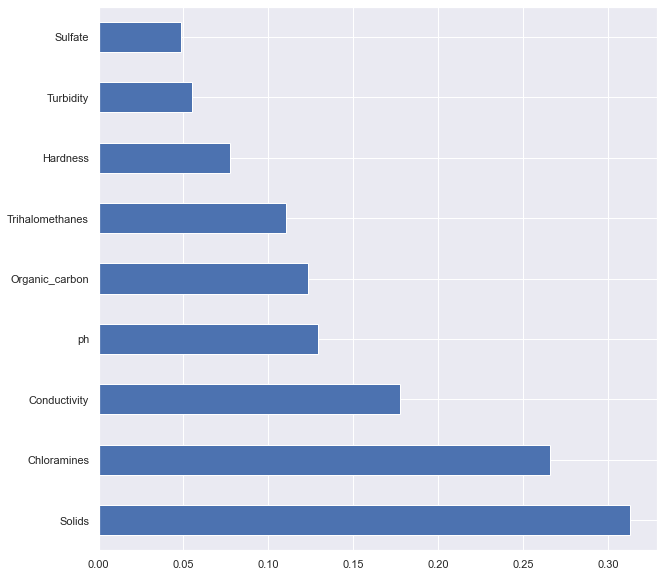

In [364]:
model_SVC = SVC(C=100, gamma = 0.01, probability = True, kernel = 'linear')
model_SVC.fit(X_train, y_train)
pd.Series(abs(model_SVC.coef_[0]), index=X.columns).nlargest(10).plot(kind='barh')

## 9. Conclusion and Interpretation
The final model is generally okay. I was expecting better results from the model, however, given that we were only working with general models for learning purposes, the results are fair. Each of the 3 best cross-validated models were able to improve their validation scores with tuning of their respective hyperparameters. The best model (SVC with optimized hyperparameters), performed slightly better than Random Forest Classifier and Gradient Boosting Classifier. This was a slight change from Lab 3 where SVC came in third place among the top three classifiers. 

I do feel that the final model is overfitted slightly, due to the high training scores.

In regards to feature importance, it is interesting to see Solids take top spot. I was expecting ph to be in the top three but it was only 4th best. 

Another thing to note is that the dataset decreased significantly (~20%) when null values were removed. This may have had an impact on model performance despite the use of cross-validation.

## 10. Reflection

This was an interesting project as it demonstrated machine learning in the real world. This was an example where potentially life or death is on the line as a result of the classification model and goes to show the importance of correct modelling.  

Next time I will definitely choose different models to include in the classifiers. This would give me a wider range of cross-validated values to choose from in step 4. 

Overall I learnt a lot not only during this project but during this course. For that I am grateful to Dr. Pauchard and his TA's. Thank you!